In [3]:
import pandas as pd
import numpy as np
import re
!pip install openpyxl

import warnings
warnings.filterwarnings("ignore")
#pd.set_option('max_columns', None)

# Data Cleaning

In [18]:
#intialize a dictionary for all the tables as keys and information we extract from each 
#table as its value
#IMS is International migrant stock
#RMS refugee migrant stock

dict_ = {'Table 1' : 'IMS' , 
         'Table 2' : 'total_population', 
         'Table 3' : 'IMS_total_population' , 
         'Table 4' : 'female_IMS', 
         'Table 5' : 'IMS_ROC' , 
         'Table 6' : ['RMS' , 'RMS_IMS','RMS_ROC']}

In [19]:
def get_annex(df):
    #annex = pd.read_excel(io="UN_MigrantStockTotal_2015.xlsx", sheet_name= "ANNEX" , index_col=False)
    df.drop(df.index[0:14] , inplace = True)
    df.drop(columns={'Unnamed: 2' , 'Unnamed: 5', 'Unnamed: 8'} , inplace = True)
    df.rename({'Unnamed: 0' : 'country_code' , 
              'Unnamed: 1' : 'country' ,
              'Unnamed: 3' : 'major_area',
              'Unnamed: 4' : 'major_area_code',
              'Unnamed: 6' : 'region',
              'Unnamed: 7' : 'region_code',
              'Unnamed: 9' : 'developed_region',
              'Unnamed: 10' : 'least_developed_country',
              'Unnamed: 11' : 'sub_saharan_africa'}, axis = 'columns' , inplace = True)
    df.reset_index(drop = True , inplace = True)
    return df

In [20]:
def get_data_type(df):
    df.drop(df.index[0:23] , inplace = True)
    df.rename({'Unnamed: 3' : 'country_code' , 'Unnamed: 4' : 'type_of_data'} , axis = 'columns' , inplace = True)
    df1 = df[['country_code' , 'type_of_data']]
    df1['foreign_pop_status']  = df1.type_of_data.str.extract(pat = '(B|C)')
    df1['refugee_incl']  = df1.type_of_data.str.extract(pat = '(R)')
    df1['imputation']  = df1.type_of_data.str.extract(pat = '(I)')
    df1.replace({'foreign_pop_status' : {'B' : 'born' , 'C' : 'citizen'}}, inplace = True) 
    df1.replace({'refugee_incl' : {'R' : 'yes' , np.nan : 'no'}}, inplace = True)
    df1.replace({'imputation' : {'I' : 'yes' , np.nan : 'no'}} , inplace = True)
    df1.drop(columns = 'type_of_data' , inplace = True)
    df1.reset_index(drop = True , inplace = True)
    return df1

In [21]:
#define a function to rename columns as it is a repetitive task
#all columns are named as 1,2,3.. when we load dataframe in python so 'i' is the starting value
#loop will start from column 'i'

def rename_columns(df1):
    #label read the value from df where the column header from excel file is stored
    label = df1.iloc[0][df1.columns[1]]
    
    #loop starting from second column till end because we dont want to rename country code
    lst = list(df1.columns[1:len(df1.columns)])
    
    for each in lst:
        #condition to check if first index(column header) is still the same
        #when value at 0 index changes label will be updated with the new value
        if(pd.notnull(df1.iloc[0][each])):
            label = df1.iloc[0][each]
       
        #code to rename column
        df1.rename({each : str(df1.iloc[1][each])+str(label).lower()} , axis = 'columns' , inplace = True)

    return df1


In [22]:
#funtion to clean table

def clean_table(df , key): 
    #remove first 13 rows as the contain the header of the table and lots of nan values
    df.drop(df.index[0:13] , inplace = True)
    
    #rename 3rd column as country code
    df.rename({'Unnamed: 3' : 'country_code' }, axis = 'columns' , inplace = True)
   
    #drop sort order, notes and type of data columns
    df.drop(columns=['Unnamed: 0' , 'Unnamed: 1' , 'Unnamed: 2'] , inplace = True)
    
    #condition because table 2 does not have type of data so we need to skip for table 2
    if(key!=dict_['Table 2']):
        df.drop(columns=['Unnamed: 4'] , inplace = True)
        
    #function call to rename rest of the columns
    df = rename_columns(df)
    
    #drop top 9 rows till sub-saharan africa as it is just summary data which can be easily
    #derived through simple code in python
    #df.drop(df.index[0:7] , inplace = True)
    
    #use melt function to change orientation of data
    #two new columns will be formed tmp will contain all the column headers
    #key value that we stored in dict_ will form the other columns
   
    df_v1 = pd.melt(df, id_vars = 'country_code', 
                    value_vars = list(df.columns[1:len(df.columns)]), 
                    var_name = "tmp" , 
                    value_name = key)
   
    #check for missing values
    df_v1[key].replace({'..' : np.nan}, inplace=True)
    #extract year from tmp column
    df_v1['year']  = df_v1.tmp.str.extract(pat = '([0-9-]+)')
    
    #extract sex from tmp column
    df_v1['sex']  = df_v1.tmp.str.extract(pat = '(?i)(both|male|female)')
    
    #drop tmp as useful info has been obtained
    df_v1.drop(columns = "tmp" , inplace = True)
    df_v1.reset_index()
    return df_v1


In [23]:
def get_table():

#main table
    df2 = pd.DataFrame()

#rate of change dataframe
    df3 = pd.DataFrame()
    lst_ = []
    flag = False

    for key in dict_:
        df = pd.read_excel(io="UN_MigrantStockTotal_2015.xlsx", sheet_name= key , index_col=False)
    
        if(key == 'Table 6'):
            df1 = clean_table(df[list(df.columns[0:11])].copy(), dict_[key][0])
            df2 = pd.merge(df2,df1 , on = ['country_code' , 'year' , 'sex'], how = 'left')

            df1 = clean_table(df[list(df.columns[[0,1,2,3,4,11,12,13,14,15,16]])].copy() , dict_[key][1])
            df2 = pd.merge(df2,df1 , on = ['country_code' , 'year'], how = 'left').drop(columns = ['sex_y'])

            df1 = clean_table(df[list(df.columns[[0,1,2,3,4,17,18,19,20,21]])].copy() , dict_[key][2])
            flag = True
   
        else:
            df1 = clean_table(df , dict_[key])
    
    #list of all tables
        lst_.append(df1)
    
    #add IMS_ROC to df3
        if(key == 'Table 5'):
            flag = True
        
    #join tables
        if (flag != True):
            if(df2.empty):
                df2 = df1
            else:
                if(key != 'Table 4'):
                    df2 = pd.merge(df2,df1 , on = ['country_code' , 'year' , 'sex'], how = 'outer')
                else:
                    df2 = pd.merge(df2,df1 , on = ['country_code' , 'year' , 'sex'], how = 'outer')
        else:
            if(df3.empty): 
                df3 = df1
                flag = False
            else:
                df3 = pd.merge(df3,df1, on = ['country_code' , 'year'], how = 'left').drop(columns = ['sex_y'])
                df3.rename({'sex_x' : 'sex'} , axis = 'columns', inplace = True)
                flag = False
        df2.rename({'sex_x' : 'sex'} , axis = 'columns', inplace = True)
    

#print(df2.groupby(by = ['country_code' , 'year' , 'sex']).size().head(50))


#join all table with annex
    annex = (get_annex(pd.read_excel(io="UN_MigrantStockTotal_2015.xlsx", sheet_name= 'ANNEX' , index_col=False)))
    tmp = pd.merge(annex,df2, on = 'country_code' , how = 'left')

#join with datatype
    datatype = get_data_type(pd.read_excel(io="UN_MigrantStockTotal_2015.xlsx", sheet_name= "Table 1" , index_col=False))

#make one column for underdeveloped and developed
    final_table = pd.merge(tmp, datatype, on = 'country_code' , how = 'left')
    final_table.replace({'developed_region' : {'Yes' : 'more' , 'No' : 'less'}}, inplace = True) 
    final_table.replace({'least_developed_country' : {'Yes' : 'least' , 'No' : 'less'}}, inplace = True) 
    final_table['country_classification'] = final_table['developed_region'] + final_table['least_developed_country']
    final_table['country_classification'].replace('lessleast', 'least', inplace=True)
    final_table['country_classification'].replace('moreless', 'more', inplace=True)
    final_table['country_classification'].replace('lessless', 'less', inplace=True)
    final_table.drop(columns = ['developed_region' , 'least_developed_country'] , inplace = True)


    final_roc = pd.merge(annex, df3, on = 'country_code' , how = 'left')
    final_roc.drop(columns = ['country', 'major_area', 'major_area_code', 'region', 'region_code', 'developed_region','least_developed_country', 'sub_saharan_africa'] , inplace = True)

   # print(display(final_roc))
   # print(display(final_table))
    
    return final_table 
#print(final_table['population_citz_status'].unique())

In [24]:
#Read notes
notes = pd.read_excel(io="UN_MigrantStockTotal_2015.xlsx", sheet_name= "NOTES" , index_col=False)
notes.drop(notes.index[0:14] , inplace = True)
notes.rename(columns={"Unnamed: 0": "code", "Unnamed: 1": "notes"} , inplace = True)
notes.set_index('code', inplace=True)

# Data Visualizations

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
pd.set_option("display.precision", 2)

# Preparing data for visualization

In [26]:
final_table = get_table()
df = final_table
df

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
0,4,Afghanistan,Asia,935,Southern Asia,5501,No,57686,1990,both,12067.57,0.48,NaN,25,0.04,born,no,no,least
1,4,Afghanistan,Asia,935,Southern Asia,5501,No,71522,1995,both,16772.52,0.43,NaN,19605,27.41,born,no,no,least
2,4,Afghanistan,Asia,935,Southern Asia,5501,No,75917,2000,both,19701.94,0.39,NaN,0,0,born,no,no,least
3,4,Afghanistan,Asia,935,Southern Asia,5501,No,87300,2005,both,24399.95,0.36,NaN,32,0.04,born,no,no,least
4,4,Afghanistan,Asia,935,Southern Asia,5501,No,102246.0,2010,both,27962.21,0.37,NaN,6434.0,6.29,born,no,no,least
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4171,716,Zimbabwe,Africa,903,Eastern Africa,910,Yes,185214,1995,female,5877.5,3.15,42.95,NaN,0.12,born,yes,no,less
4172,716,Zimbabwe,Africa,903,Eastern Africa,910,Yes,176198,2000,female,6280.13,2.81,42.97,NaN,1.01,born,yes,no,less
4173,716,Zimbabwe,Africa,903,Eastern Africa,910,Yes,168723,2005,female,6548.18,2.58,42.97,NaN,1.13,born,yes,no,less
4174,716,Zimbabwe,Africa,903,Eastern Africa,910,Yes,170924.0,2010,female,7068.86,2.42,42.96,NaN,1.11,born,yes,no,less


# Tufte's 1st Principle : Sort 

Sort based on Country Code

In [27]:
x = df.sort_values(by='IMS' , ascending = False)
y = df.sort_values(by='IMS' , ascending = True)

x.head(10)

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
3965,840,United States of America,Northern America,905,Northern America,905,No,46627102.0,2015,both,321773.63,14.49,NaN,263662.0,0.57,born,no,no,more
3964,840,United States of America,Northern America,905,Northern America,905,No,44183643.0,2010,both,309876.17,14.26,NaN,264574.0,0.6,born,no,no,more
3963,840,United States of America,Northern America,905,Northern America,905,No,39258293,2005,both,296139.64,13.26,NaN,379340,0.97,born,no,no,more
3962,840,United States of America,Northern America,905,Northern America,905,No,34814053,2000,both,282895.74,12.31,NaN,508222,1.46,born,no,no,more
3961,840,United States of America,Northern America,905,Northern America,905,No,28451053,1995,both,266275.53,10.68,NaN,623294,2.19,born,no,no,more
3977,840,United States of America,Northern America,905,Northern America,905,No,23802795.0,2015,female,162279.86,14.67,51.05,NaN,0.57,born,no,no,more
3960,840,United States of America,Northern America,905,Northern America,905,No,23251026,1990,both,252847.81,9.2,NaN,438193,1.88,born,no,no,more
3971,840,United States of America,Northern America,905,Northern America,905,No,22824307.0,2015,male,159493.77,14.31,NaN,NaN,0.57,born,no,no,more
3976,840,United States of America,Northern America,905,Northern America,905,No,22489474.0,2010,female,156584.49,14.36,50.9,NaN,0.6,born,no,no,more
3970,840,United States of America,Northern America,905,Northern America,905,No,21694169.0,2010,male,153291.68,14.15,NaN,NaN,0.6,born,no,no,more


In [28]:
y.head(5)

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
3869,798,Tuvalu,Oceania,909,Polynesia,957,No,63.0,2015,female,NaN,NaN,44.68,NaN,0.0,citizen,no,no,least
3868,798,Tuvalu,Oceania,909,Polynesia,957,No,69.0,2010,female,NaN,NaN,44.81,NaN,0.0,citizen,no,no,least
3863,798,Tuvalu,Oceania,909,Polynesia,957,No,78.0,2015,male,NaN,NaN,NaN,NaN,0.0,citizen,no,no,least
3867,798,Tuvalu,Oceania,909,Polynesia,957,No,82,2005,female,NaN,NaN,44.81,NaN,0,citizen,no,no,least
3862,798,Tuvalu,Oceania,909,Polynesia,957,No,85.0,2010,male,NaN,NaN,NaN,NaN,0.0,citizen,no,no,least


In [29]:
df2 = df.sort_values(by='total_population' , ascending = False)
df2

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
779,156,China,Asia,935,Eastern Asia,906,No,978046.0,2015,both,1376048.94,0.07,NaN,301052.0,30.78,citizen,no,no,less
778,156,China,Asia,935,Eastern Asia,906,No,849861.0,2010,both,1340968.74,0.06,NaN,300986.0,35.42,citizen,no,no,less
1751,356,India,Asia,935,Southern Asia,5501,No,5240960.0,2015,both,1311050.53,0.4,NaN,198665.0,3.79,born,yes,no,less
777,156,China,Asia,935,Eastern Asia,906,No,678947,2005,both,1305600.63,0.05,NaN,297346,43.8,citizen,no,no,less
776,156,China,Asia,935,Eastern Asia,906,No,508034,2000,both,1269974.57,0.04,NaN,293705,57.81,citizen,no,no,less
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099,876,Wallis and Futuna Islands,Oceania,909,Polynesia,957,No,821,1995,female,NaN,NaN,48.87,NaN,0,born,no,no,less
4100,876,Wallis and Futuna Islands,Oceania,909,Polynesia,957,No,997,2000,female,NaN,NaN,49.48,NaN,0,born,no,no,less
4101,876,Wallis and Futuna Islands,Oceania,909,Polynesia,957,No,1171,2005,female,NaN,NaN,49.51,NaN,0,born,no,no,less
4102,876,Wallis and Futuna Islands,Oceania,909,Polynesia,957,No,1375.0,2010,female,NaN,NaN,49.53,NaN,0.0,born,no,no,less


# Tufte's 2nd Principle : Group

###### Aggregate international migrant stock by region, sex and year 

In [30]:
ims_region = df.groupby(['region', 'sex', 'year'])['IMS'].sum().unstack().fillna(0)
ims_region

year                                  1990      1995      2000      2005  \
region                    sex                                              
Australia and New Zealand both     4473260   4741947   5065063   5717982   
                          female   2201841   2359437   2545236   2891102   
                          male     2271419   2382510   2519827   2826880   
Caribbean                 both     1056555   1154700   1255647   1328740   
                          female    506889    558008    610543    648026   
...                                    ...       ...       ...       ...   
Western Asia              female   6317950   6960145   7496995   8294747   
                          male     8921324   9996494  11062014  13363900   
Western Europe            both    16237829  18318040  20425378  22776284   
                          female   7731651   8965592  10212028  11613877   
                          male     8506178   9352448  10213350  11162407   

year                                  2010      2015  
region                    sex                         
Australia and New Zealand both    6.83e+06  7.80e+06  
                          female  3.45e+06  3.96e+06  
                          male    3.38e+06  3.84e+06  
Caribbean                 both    1.35e+06  1.37e+06  
                          female  6.57e+05  6.66e+05  
...                                    ...       ...  
Western Asia              female  1.07e+07  1.36e+07  
                          male    1.99e+07  2.46e+07  
Western Europe            both    2.52e+07  2.74e+07  
                          female  1.32e+07  1.42e+07  
                          male    1.21e+07  1.32e+07  

[66 rows x 6 columns]

###### Aggregate refugee migrant stock by region and year for both male & female

In [31]:
rms_region = df.groupby(['region', 'year'])['RMS'].sum().unstack().fillna(0)
rms_region

year,1990,1995,2000,2005,2010,2015
region,,,,,,
Australia and New Zealand,102581,82839,76169,72029,2.78e+04,4.94e+04
Caribbean,6632,3529,1609,1367,1.20e+03,1.06e+03
Central America,1162216,313977,37295,26083,3.84e+04,4.00e+04
Central Asia,3000,40778,96316,70790,1.04e+04,3.50e+03
Eastern Africa,3168001,2046088,1641559,1419685,1.01e+06,2.09e+06
Eastern Asia,302529,300610,298442,299923,3.04e+05,3.05e+05
Eastern Europe,36062,22822,40515,25743,3.86e+04,2.76e+05
Melanesia,7099,9601,5863,10000,4.70e+03,4.81e+03
Micronesia,0,0,0,0,0.00e+00,3.90e+02


##### Aggreagate international migrant stock by major areas, year and sex

In [32]:
ims_area = df.groupby(['major_area', 'sex', 'year'])['IMS'].sum().unstack().fillna(0)
ims_area

year                                        1990      1995      2000  \
major_area                      sex                                    
Africa                          both    15690623  16352814  14800306   
                                female   7411059   7735883   6943948   
                                male     8279564   8616931   7856358   
Asia                            both    48142261  46548225  49340815   
                                female  22130386  21350703  22492144   
                                male    26011875  25197522  26848671   
Europe                          both    49219200  52842663  56271885   
                                female  25272527  27206857  29035823   
                                male    23946673  25635806  27236062   
Latin America and the Caribbean both     7169728   6694640   6578428   
                                female   3572691   3344871   3294753   
                                male     3597037   3349769   3283675   
Northern America                both    27610542  33341147  40351848   
                                female  14113223  16939146  20367918   
                                male    13497319  16402001  19983930   
Oceania                         both     4730858   5022263   5360027   
                                female   2315816   2486815   2683884   
                                male     2415042   2535448   2676143   

year                                        2005      2010      2015  
major_area                      sex                                   
Africa                          both    15191146  1.68e+07  2.06e+07  
                                female   6959709  7.80e+06  9.53e+06  
                                male     8231437  9.04e+06  1.11e+07  
Asia                            both    53371224  6.59e+07  7.51e+07  
                                female  23785993  2.77e+07  3.15e+07  
                                male    29585231  3.82e+07  4.36e+07  
Europe                          both    64086824  7.24e+07  7.61e+07  
                                female  33165199  3.77e+07  3.99e+07  
                                male    30921625  3.47e+07  3.63e+07  
Latin America and the Caribbean both     7233098  8.24e+06  9.23e+06  
                                female   3638342  4.15e+06  4.65e+06  
                                male     3594756  4.09e+06  4.58e+06  
Northern America                both    45363387  5.12e+07  5.45e+07  
                                female  22818659  2.62e+07  2.79e+07  
                                male    22544728  2.51e+07  2.66e+07  
Oceania                         both     6023421  7.13e+06  8.10e+06  
                                female   3034524  3.59e+06  4.10e+06  
                                male     2988897  3.54e+06  4.00e+06

###### Aggregate refugee migrant stock by major areas and year

In [33]:
rms_area = df.groupby(['major_area', 'year'])['RMS'].sum().unstack().fillna(0)
rms_area

year,1990,1995,2000,2005,2010,2015
major_area,,,,,,
Africa,5687352,5949953,3609138,2750644,2.41e+06,4.02e+06
Asia,9937007,7937682,9175210,8109615,1.05e+07,1.32e+07
Europe,1321884,2746090,2283959,1760748,1.59e+06,1.48e+06
Latin America and the Caribbean,1197198,352256,44088,47186,3.76e+05,3.84e+05
Northern America,583450,775419,633376,526511,4.30e+05,4.24e+05
Oceania,109680,92440,82032,82029,3.25e+04,5.46e+04


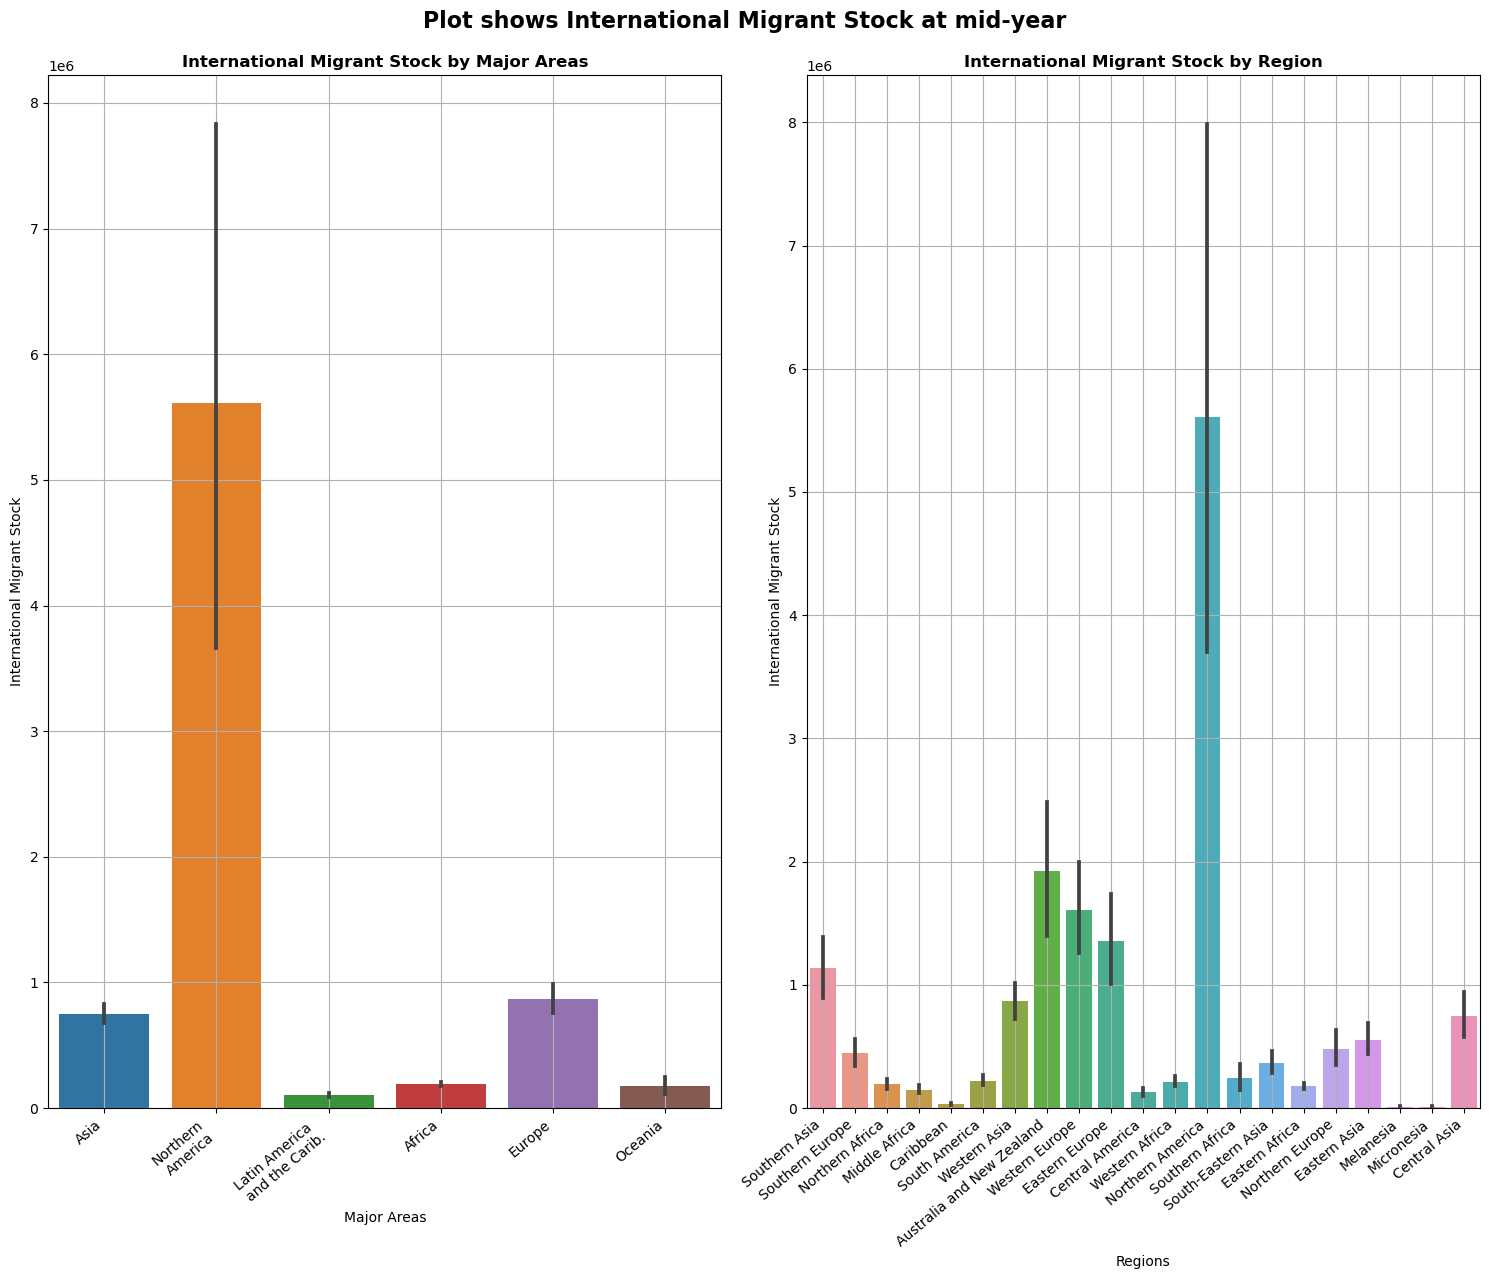

In [34]:
df1 = df[df['sex'] != 'both']
df2['major_area'].replace({'Latin America and the Caribbean' : 'Latin America \nand the Carib.'} , inplace = True)
df2['major_area'].replace( {'Northern America' : 'Northern\nAmerica'} , inplace = True)
df1 = df.drop(df[df.region == 'Polynesia'].index) 

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,13))
f.suptitle('Plot shows International Migrant Stock at mid-year',fontweight='bold',fontsize=16)

ax1.set_title('International Migrant Stock by Major Areas',fontweight="bold")
sns.barplot(data=df2, x = 'major_area' , y = 'IMS', ax=ax1)
sns.color_palette("Spectral", as_cmap=True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax1.set_ylabel('International Migrant Stock')
ax1.set_xlabel('Major Areas')
ax1.grid()

ax2.set_title('International Migrant Stock by Region',fontweight="bold")
sns.barplot(data=df1, x = 'region' , y = 'IMS', ax=ax2)
ax2.set_ylabel('International Migrant Stock')
ax2.set_xlabel('Regions')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
ax2.grid()

f.tight_layout()
f.subplots_adjust(top=.93)
plt.show()


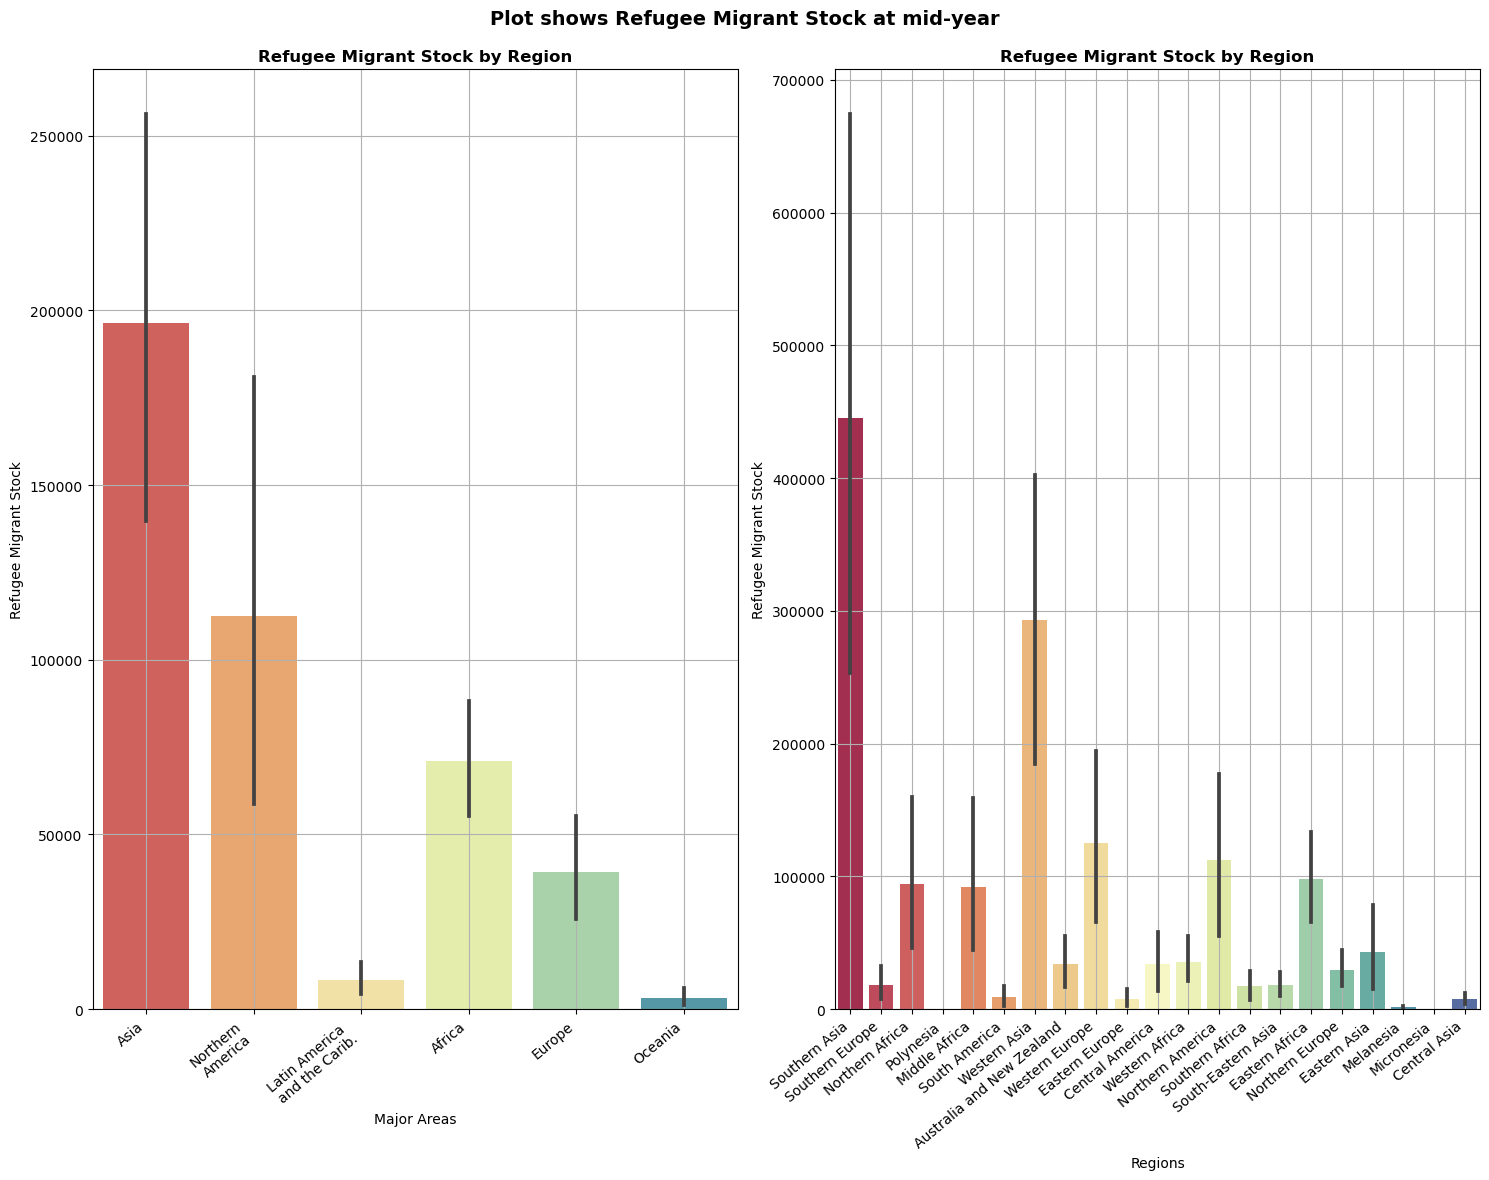

In [35]:
#remove regions for which we do not have data
df1 = df.drop(df[df['region'] == 'Polynesia'].index) 
df1 = df.drop(df1[df1['region'] == 'Micronesia'].index)
df1 = df.drop(df1[df1['region'] == 'Caribbean'].index)
df2['major_area'].replace({'Latin America and the Caribbean' : 'Latin America \nand the Carib.'} , inplace = True)
df2['major_area'].replace( {'Northern America' : 'Northern\nAmerica'} , inplace = True)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,12))
f.suptitle('Plot shows Refugee Migrant Stock at mid-year',fontweight='bold',fontsize=14)

ax2.set_title('Refugee Migrant Stock by Region',fontweight="bold")
sns.barplot(data=df1, x = 'region' , y = 'RMS' , ax=ax2 , palette = "Spectral")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
ax2.set_ylabel('Refugee Migrant Stock')
ax2.set_xlabel('Regions')
ax2.grid()

ax1.set_title('Refugee Migrant Stock by Region',fontweight="bold")
sns.barplot(data=df2, x = 'major_area' , y = 'RMS' , ax=ax1,palette = "Spectral")
ax1.set_ylabel('Refugee Migrant Stock')
ax1.set_xlabel('Major Areas')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax1.grid()

f.tight_layout()
f.subplots_adjust(top=.93)
plt.show()

# Tufte's 3rd Principle : Subset

###### Create a smaller subset of data for Sub Saharan Africa

In [36]:
df1 = df[df['sub_saharan_africa'] == 'Yes']
df1.head()

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
90,24,Angola,Africa,903,Middle Africa,911,Yes,33517,1990,both,11127.87,0.3,NaN,12000,35.8,born,yes,no,least
91,24,Angola,Africa,903,Middle Africa,911,Yes,39813,1995,both,13042.67,0.31,NaN,11404,28.64,born,yes,no,least
92,24,Angola,Africa,903,Middle Africa,911,Yes,46108,2000,both,15058.64,0.31,NaN,12579,27.28,born,yes,no,least
93,24,Angola,Africa,903,Middle Africa,911,Yes,61329,2005,both,17912.94,0.34,NaN,13867,22.61,born,yes,no,least
94,24,Angola,Africa,903,Middle Africa,911,Yes,76549.0,2010,both,21219.95,0.36,NaN,15155.0,19.8,born,yes,no,least


In [37]:
df2 = df1.groupby(['region', 'country' , 'year'])['IMS'].sum().unstack().fillna(0)
df2

year                                                 1990     1995     2000  \
region          country                                                       
Eastern Africa  Burundi                            666220   509706   251256   
                Comoros                             28158    27878    27598   
                Djibouti                           244442   199548   201014   
                Eritrea                             23696    24800    25904   
                Ethiopia                          2310780  1613808  1222768   
                Kenya                              594584  1237490  1398278   
                Madagascar                          47834    42354    47082   
                Malawi                            2255448   483248   465240   
                Mauritius                            7226    14986    31086   
                Mayotte                             30458    52632    90948   
                Mozambique                         244664   336512   391404   
                Rwanda                             319738   466400   694152   
                Réunion                            114420   154318   201356   
                Seychelles                           7442    10296    13148   
                Somalia                            956588    39054    40174   
                South Sudan                             0        0        0   
                Uganda                            1116614  1269240  1269406   
                United Republic of Tanzania       1148050  2212086  1856360   
                Zambia                             558058   488676   642334   
                Zimbabwe                          1253642   862452   820082   
Middle Africa   Angola                              67034    79626    92216   
                Cameroon                           530688   493728   456766   
                Central African Republic           134468   199424   247058   
                Chad                               148684   179168   209650   
                Congo                              259194   383270   610004   
                Democratic Republic of the Congo  1508388  3633926  1488774   
                Equatorial Guinea                    5480     7258     9034   
                Gabon                              255960   305944   391142   
                Sao Tome and Principe               11164     9872     8730   
Northern Africa Sudan                             2805792  2106792  1603766   
Southern Africa Botswana                            55020    80336   114128   
                Lesotho                             16480    14408    12334   
                Namibia                            241282   230744   268806   
                South Africa                      2327766  2007614  2003650   
                Swaziland                          144170    50062    45710   
Western Africa  Benin                              152424   209942   267460   
                Burkina Faso                       699314   869696  1040078   
                Cabo Verde                          17862    19958    22054   
                Côte d'Ivoire                     3632852  4152788  3988270   
                Gambia                             236246   301780   365028   
                Ghana                              329702   505758   383202   
                Guinea                             807242  1549010  1120150   
                Guinea-Bissau                       30736    55922    40900   
                Liberia                            189928   417126   303736   
                Mali                               321472   352374   378950   
                Mauritania                         223300   179124   114732   
                Niger                              230928   291998   244520   
                Nigeria                            913242   925998   975764   
                Saint Helena                      

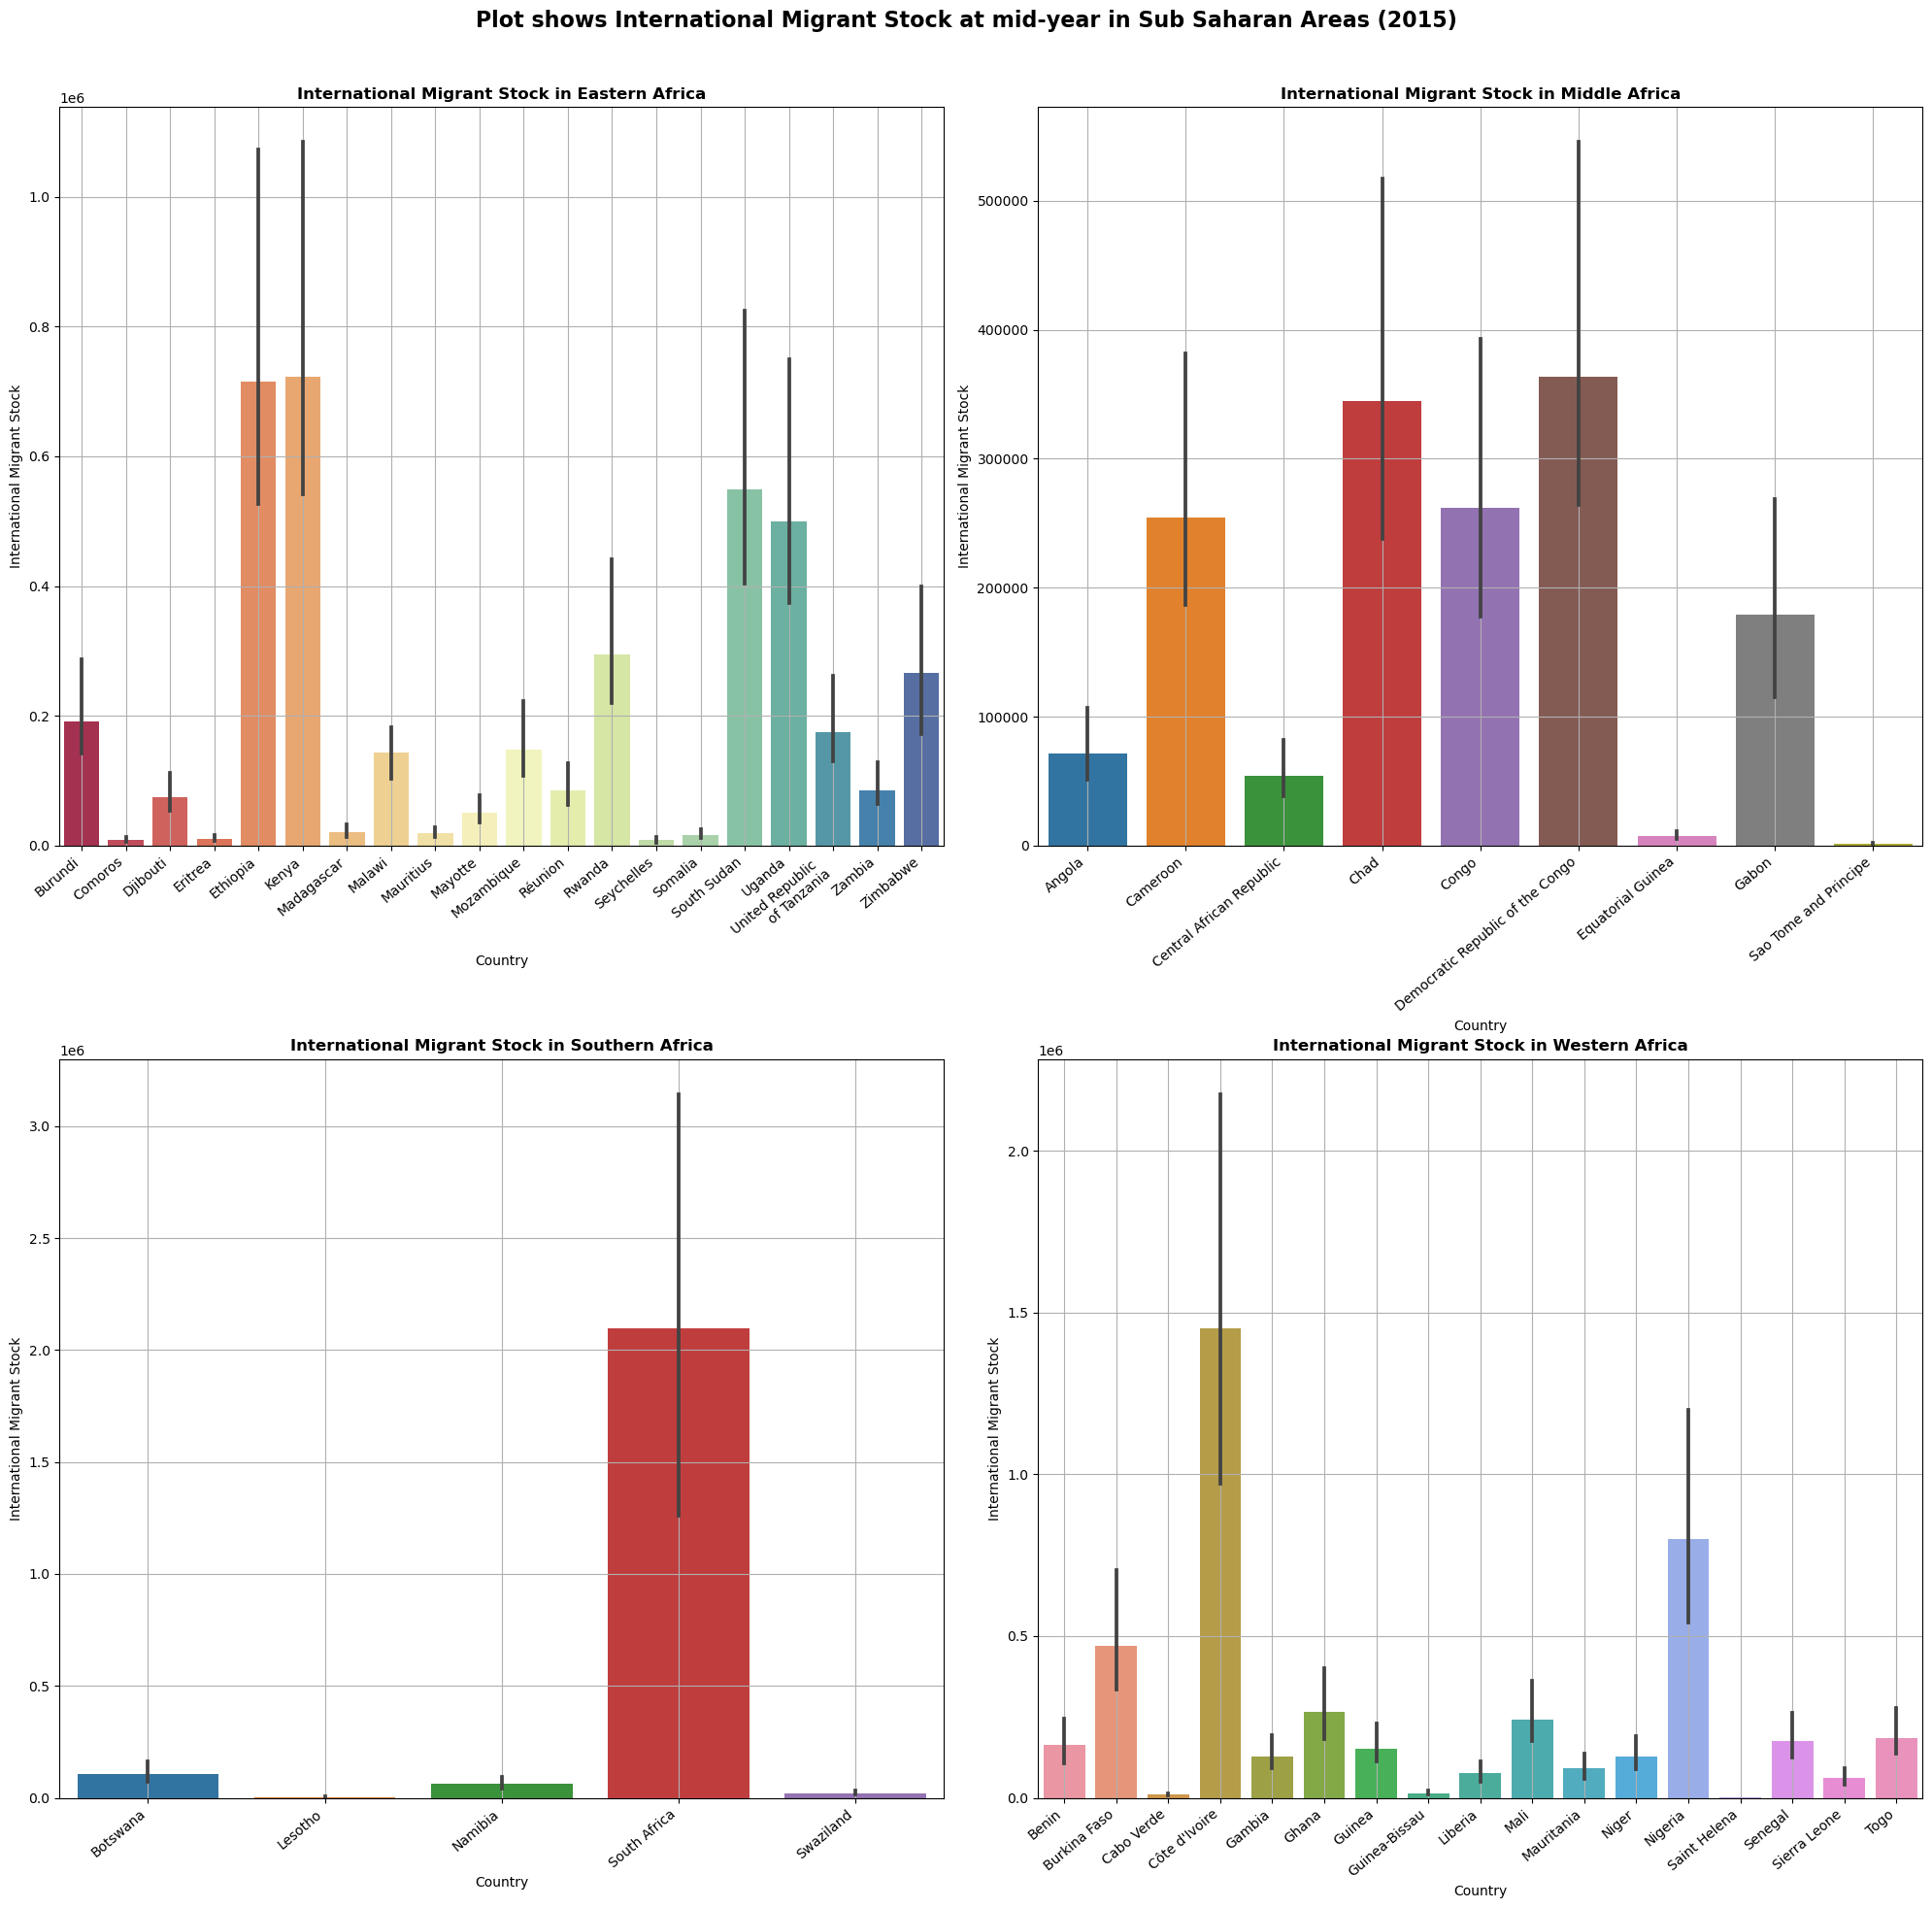

In [38]:
df['country'].replace({'United Republic of Tanzania' : 'United Republic \nof Tanzania'} , inplace = True)

f, ax = plt.subplots(2, 2, figsize=(20,20))
f.suptitle('Plot shows International Migrant Stock at mid-year in Sub Saharan Areas (2015)',fontweight='bold',fontsize=16)


ax[0,0].set_title('International Migrant Stock in Eastern Africa',fontweight="bold")
sns.barplot(data=df[(df['region'] == 'Eastern Africa') & (df['year'] == '2015')], x = 'country', y = 'IMS' ,ax=ax[0,0],palette = "Spectral")
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=40, ha="right")
ax[0,0].set_ylabel('International Migrant Stock')
ax[0,0].set_xlabel('Country')
ax[0,0].grid()

ax[0,1].set_title('International Migrant Stock in Middle Africa',fontweight="bold")
sns.barplot(data=df[(df['region'] == 'Middle Africa') & (df['year'] == '2015')], x = 'country' , y = 'IMS', ax=ax[0,1])
ax[0,1].set_ylabel('International Migrant Stock')
ax[0,1].set_xlabel('Country')
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), rotation=40, ha="right")
ax[0,1].grid()

ax[1,0].set_title('International Migrant Stock in Southern Africa',fontweight="bold")
sns.barplot(data=df[(df['region'] == 'Southern Africa') & (df['year'] == '2015')], x = 'country' , y = 'IMS', ax=ax[1,0])
ax[1,0].set_ylabel('International Migrant Stock')
ax[1,0].set_xlabel('Country')
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=40, ha="right")
ax[1,0].grid()

ax[1,1].set_title('International Migrant Stock in Western Africa',fontweight="bold")
sns.barplot(data=df[(df['region'] == 'Western Africa') & (df['year'] == '2015')], x = 'country' , y = 'IMS', ax=ax[1,1])
ax[1,1].set_ylabel('International Migrant Stock')
ax[1,1].set_xlabel('Country')
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), rotation=40, ha="right")
ax[1,1].grid()

f.tight_layout()
f.subplots_adjust(top=.93)
plt.show()

# Tufte's 4th Principle : Compare

In [39]:
df1 = df[df['region'] == 'Northern America']
df1

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
396,60,Bermuda,Northern America,905,Northern America,905,No,15683,1990,both,60.93,25.74,NaN,0,0,born,no,no,more
397,60,Bermuda,Northern America,905,Northern America,905,No,16676,1995,both,62.69,26.6,NaN,0,0,born,no,no,more
398,60,Bermuda,Northern America,905,Northern America,905,No,17668,2000,both,64.03,27.59,NaN,0,0,born,no,no,more
399,60,Bermuda,Northern America,905,Northern America,905,No,18276,2005,both,65.12,28.06,NaN,0,0,born,no,no,more
400,60,Bermuda,Northern America,905,Northern America,905,No,18884.0,2010,both,63.95,29.53,NaN,0.0,0.0,born,no,no,more
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3973,840,United States of America,Northern America,905,Northern America,905,No,14418894,1995,female,135313.42,10.66,50.68,NaN,2.19,born,no,no,more
3974,840,United States of America,Northern America,905,Northern America,905,No,17503268,2000,female,143336.59,12.21,50.28,NaN,1.46,born,no,no,more
3975,840,United States of America,Northern America,905,Northern America,905,No,19643415,2005,female,149764.2,13.12,50.04,NaN,0.97,born,no,no,more
3976,840,United States of America,Northern America,905,Northern America,905,No,22489474.0,2010,female,156584.49,14.36,50.9,NaN,0.6,born,no,no,more


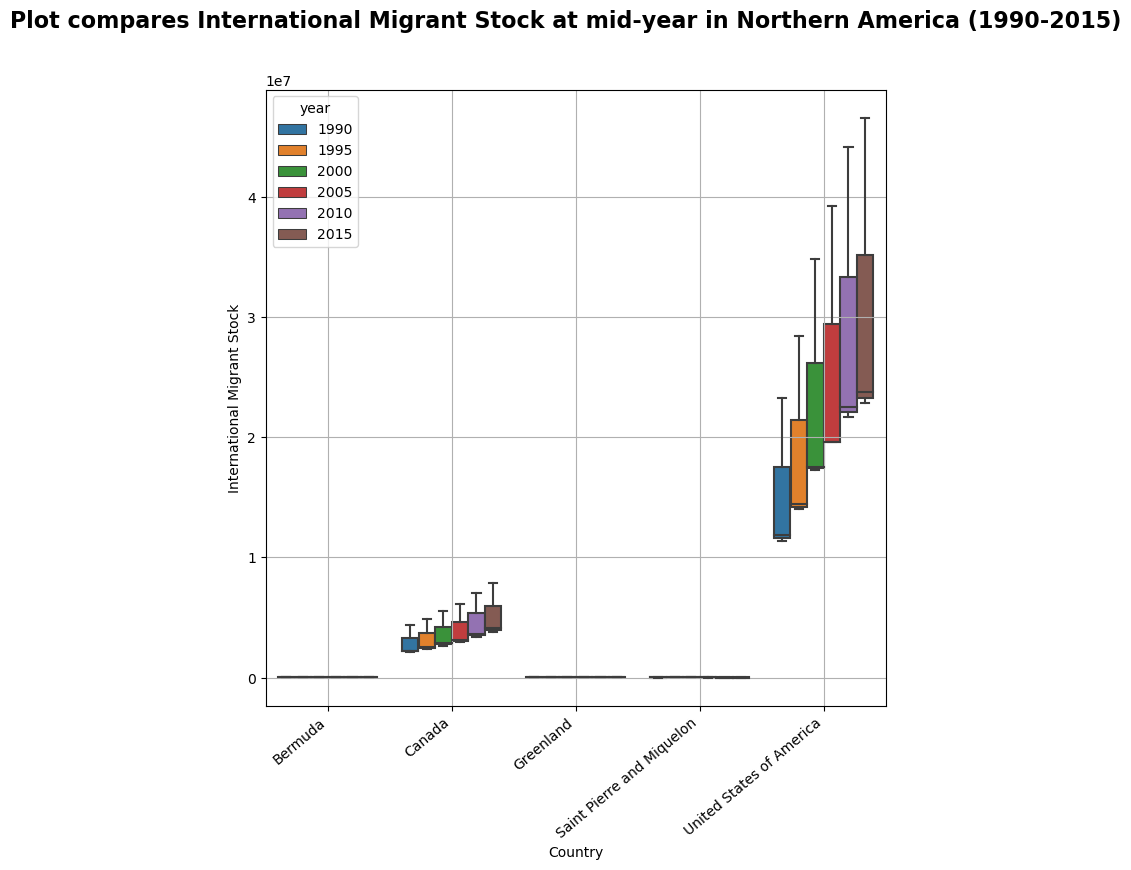

In [40]:
f, ax1 = plt.subplots(1, 1, figsize=(8,8))
f.suptitle('Plot compares International Migrant Stock at mid-year in Northern America (1990-2015)',fontweight='bold',fontsize=16)


sns.boxplot(ax = ax1, data=df1, x="country", y="IMS", hue="year" )
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax1.set_ylabel('International Migrant Stock')
ax1.set_xlabel('Country')
ax1.grid()


In [41]:
df1 = df1[(df1['country'] != 'Bermuda')]
df1 = df1[(df1['country'] != 'Greenland')]
df1 = df1[(df1['country'] != 'Saint Pierre and Miquelon')]
df1 = df1[df1['sex'] != 'both']
df1

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
636,124,Canada,Northern America,905,Northern America,905,No,2109652,1990,male,13715.67,15.38,NaN,NaN,3.35,born,no,no,more
637,124,Canada,Northern America,905,Northern America,905,No,2356105,1995,male,14502.84,16.25,NaN,NaN,3.13,born,no,no,more
638,124,Canada,Northern America,905,Northern America,905,No,2659135,2000,male,15204.35,17.49,NaN,NaN,2.27,born,no,no,more
639,124,Canada,Northern America,905,Northern America,905,No,2915838,2005,male,15986.28,18.24,NaN,NaN,2.42,born,no,no,more
640,124,Canada,Northern America,905,Northern America,905,No,3356211.0,2010,male,16926.55,19.83,NaN,NaN,2.36,born,no,no,more
641,124,Canada,Northern America,905,Northern America,905,No,3748267.0,2015,male,17826.27,21.03,NaN,NaN,2.05,born,no,no,more
642,124,Canada,Northern America,905,Northern America,905,No,2223666,1990,female,13946.77,15.94,51.32,NaN,3.35,born,no,no,more
643,124,Canada,Northern America,905,Northern America,905,No,2508673,1995,female,14796.64,16.95,51.57,NaN,3.13,born,no,no,more
644,124,Canada,Northern America,905,Northern America,905,No,2852779,2000,female,15497.55,18.41,51.76,NaN,2.27,born,no,no,more
645,124,Canada,Northern America,905,Northern America,905,No,3163147,2005,female,16270.05,19.44,52.03,NaN,2.42,born,no,no,more


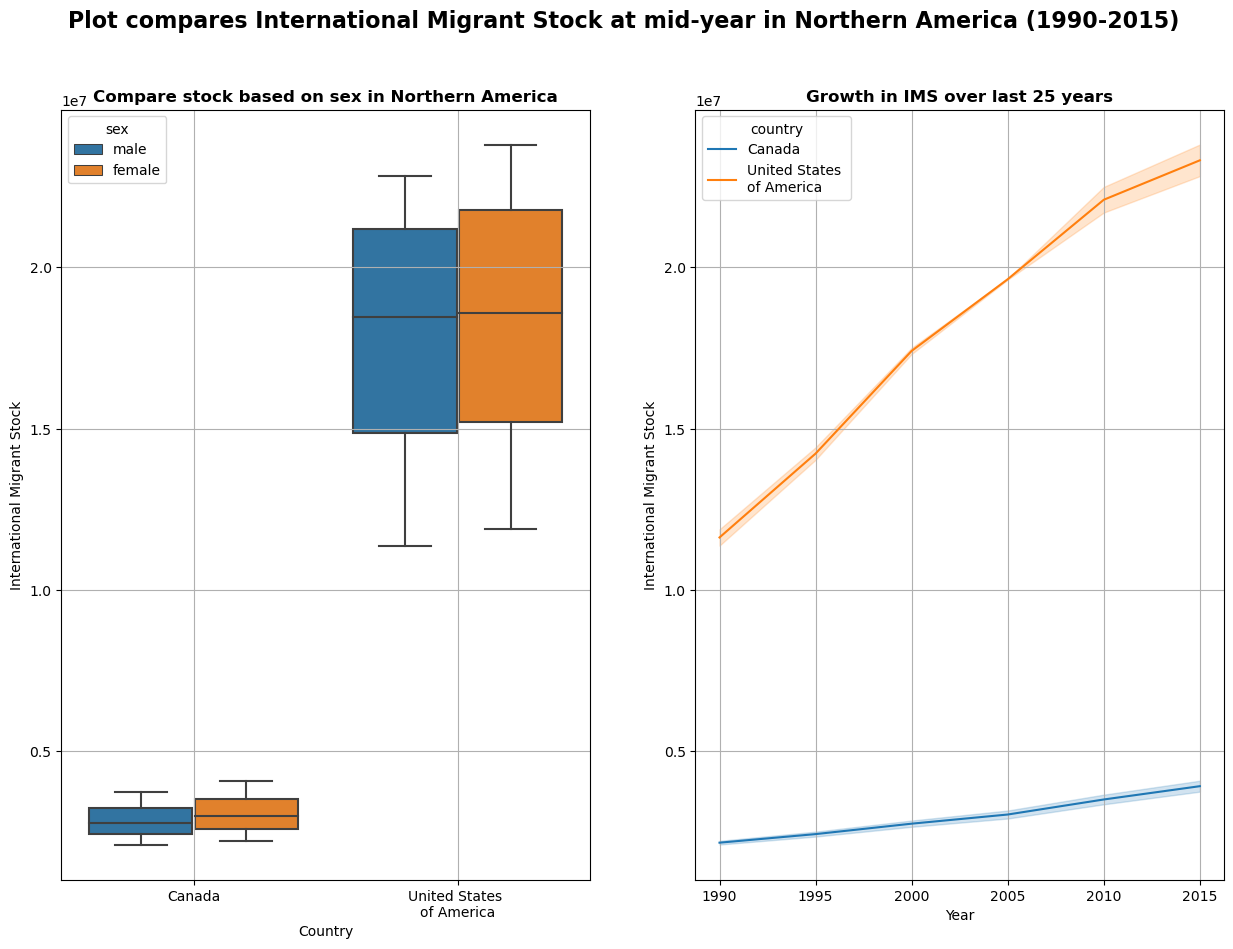

In [42]:
df1['country'].replace({'United States of America' : 'United States \nof America'} , inplace = True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.suptitle('Plot compares International Migrant Stock at mid-year in Northern America (1990-2015)',fontweight='bold',fontsize=16)


ax1.set_title('Compare stock based on sex in Northern America',fontweight="bold")
sns.boxplot(ax = ax1, data=df1, x="country", y="IMS", hue="sex" )
ax1.set_ylabel('International Migrant Stock')
ax1.set_xlabel('Country')
ax1.grid()

ax2.set_title('Growth in IMS over last 25 years',fontweight="bold")
sns.lineplot(ax = ax2, data=df1, x="year", y="IMS" , hue = 'country')
ax2.set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax2.set_ylabel('International Migrant Stock')
ax2.set_xlabel('Year')
ax2.grid()

In [43]:
df2 = df[df['sub_saharan_africa']=='Yes']
df2 = df2[df2['year'] == '2015']
df2 = df2[df2['sex'] == 'both']
df2['total_population'] = df2['total_population']*1000
df2

,country_code,country,major_area,major_area_code,region,region_code,sub_saharan_africa,IMS,year,sex,total_population,IMS_total_population,female_IMS,RMS,RMS_IMS,foreign_pop_status,refugee_incl,imputation,country_classification
95,24,Angola,Africa,903,Middle Africa,911,Yes,106845.0,2015,both,25021974.0,0.43,NaN,15474.0,14.48,born,yes,no,least
383,204,Benin,Africa,903,Western Africa,914,Yes,245399.0,2015,both,10879829.0,2.26,NaN,219.0,0.09,citizen,yes,no,least
473,72,Botswana,Africa,903,Southern Africa,913,Yes,160644.0,2015,both,2262485.0,7.1,NaN,2766.0,1.72,citizen,no,no,less
563,854,Burkina Faso,Africa,903,Western Africa,914,Yes,704676.0,2015,both,18105570.0,3.89,NaN,31894.0,4.53,born,yes,no,least
581,108,Burundi,Africa,903,Eastern Africa,910,Yes,286810.0,2015,both,11178921.0,2.57,NaN,47805.0,16.67,born,yes,no,least
617,120,Cameroon,Africa,903,Middle Africa,911,Yes,381984.0,2015,both,23344179.0,1.64,NaN,264126.0,69.15,born,no,no,less
653,132,Cabo Verde,Africa,903,Western Africa,914,Yes,14924.0,2015,both,520502.0,2.87,NaN,0.0,0.0,born,no,no,less
707,140,Central African Republic,Africa,903,Middle Africa,911,Yes,81598.0,2015,both,4900274.0,1.67,NaN,7694.0,9.43,citizen,no,no,least
725,148,Chad,Africa,903,Middle Africa,911,Yes,516968.0,2015,both,14037472.0,3.68,NaN,454882.0,87.99,born,yes,no,least
851,174,Comoros,Africa,903,Eastern Africa,910,Yes,12555.0,2015,both,788474.0,1.59,NaN,0.0,0.0,born,no,no,least


In [ ]:
df2_grouped = df2.groupby('region').sum()[['total_population' ,'IMS', 'RMS']]
df2_grouped['total_population'] = df2_grouped['total_population'] - df2_grouped['IMS'] - df2_grouped['RMS']
df2_grouped

In [ ]:
fields = ['IMS','RMS']
colors = ['#8390FA', '#6EAF46']
labels = ['IMS', 'RMS']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(df2_grouped) * [0]
for idx, name in enumerate(fields):
    plt.barh(df2_grouped.index, df2_grouped[name], left = left, color=colors[idx])
    left = left + df2_grouped[name]
# title, legend, labels
plt.title('International vs Refugee Migrant Stock in Sub-Saharan Regions in 2015\n\n\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Stock at mid-year')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

# Tufte's 5th Principle : Small Multiples

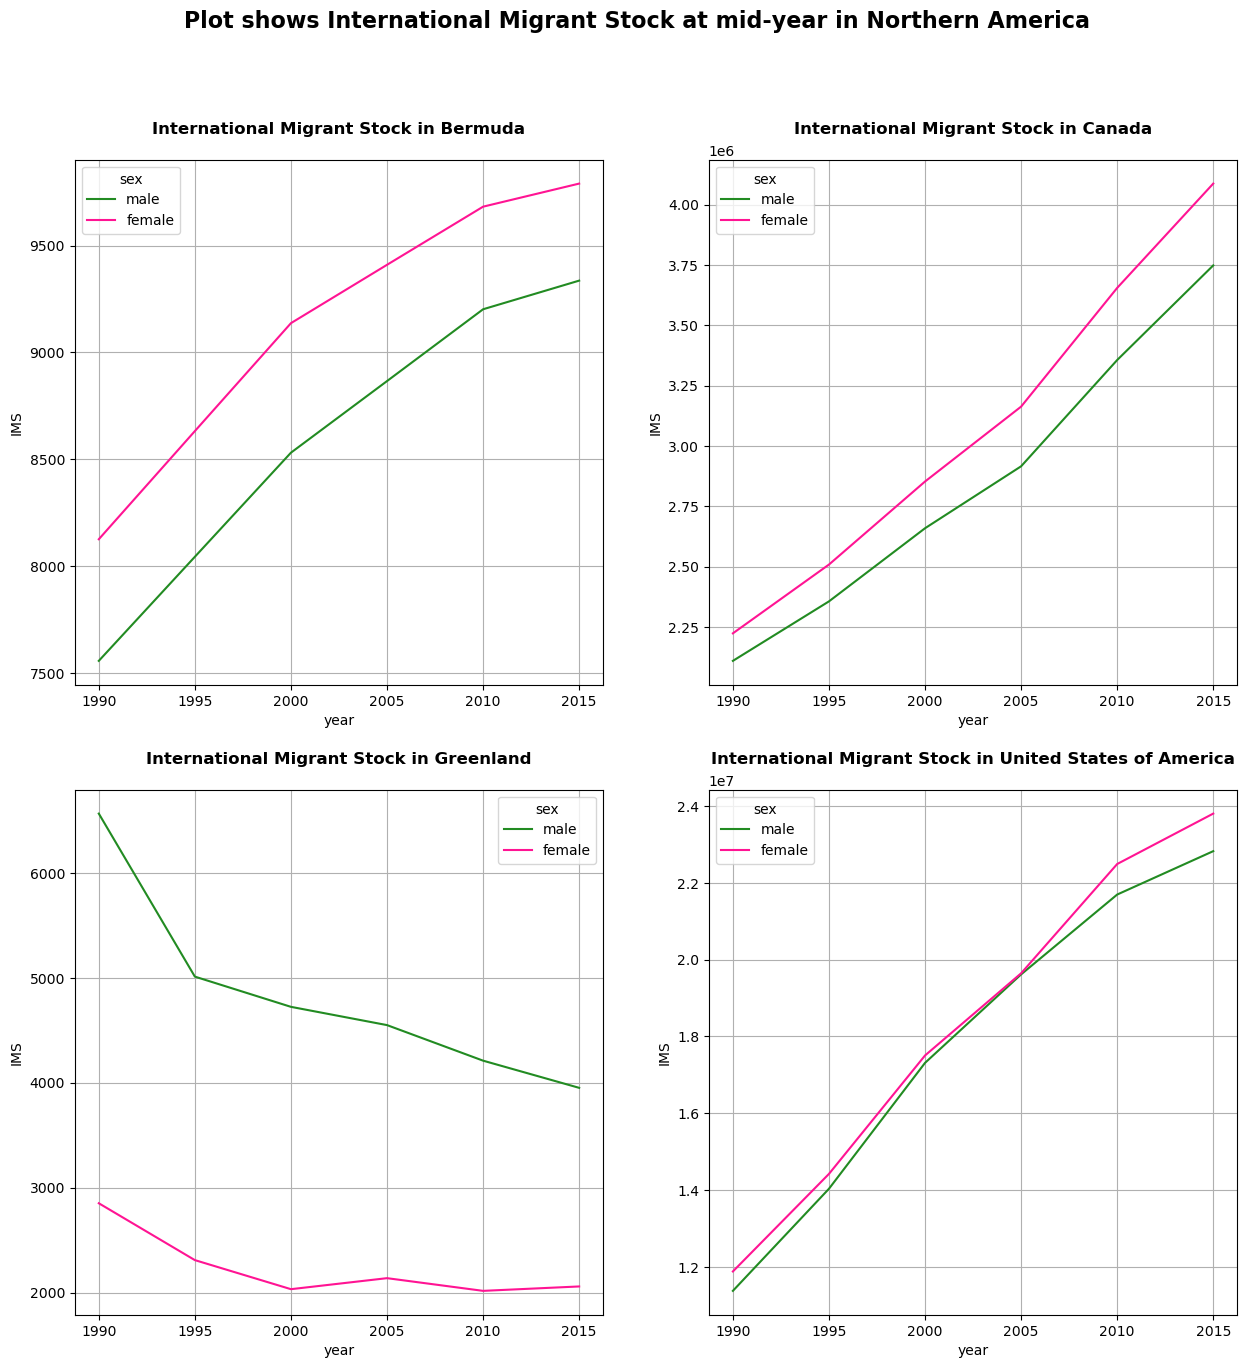

In [63]:
df1 = df[df['region'] == 'Northern America']
df1 = df1[df1['sex'] != 'both']

f, ax = plt.subplots(2,2, figsize=(15,15))
f.suptitle('Plot shows International Migrant Stock at mid-year in Northern America',fontweight='bold',fontsize=16)


ax[0,0].set_title('International Migrant Stock in Bermuda\n',fontweight="bold")
sns.lineplot(ax = ax[0,0], data=df1[df1['country'] == 'Bermuda'], x="year", y="IMS" , hue = 'sex',palette=["forestgreen", "deeppink"])
ax[0,0].set_ylabel('IMS')
ax[0,0].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[0,0].grid()

ax[0,1].set_title('International Migrant Stock in Canada\n',fontweight="bold")
sns.lineplot(ax = ax[0,1], data=df1[df1['country'] == 'Canada'], x="year", y="IMS" , hue = 'sex',palette=["forestgreen", "deeppink"])
ax[0,1].set_ylabel('IMS')
ax[0,1].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[0,1].grid()

ax[1,0].set_title('International Migrant Stock in Greenland\n',fontweight="bold")
sns.lineplot(ax = ax[1,0], data=df1[df1['country'] == 'Greenland'], x="year", y="IMS" , hue = 'sex',palette=["forestgreen", "deeppink"])
ax[1,0].set_ylabel('IMS')
ax[1,0].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[1,0].grid()

ax[1,1].set_title('International Migrant Stock in United States of America\n',fontweight="bold")
sns.lineplot(ax = ax[1,1], data=df1[df1['country'] == 'United States of America'], x="year", y="IMS" , hue = 'sex',palette=["forestgreen", "deeppink"])
ax[1,1].set_ylabel('IMS')
ax[1,1].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[1,1].grid()

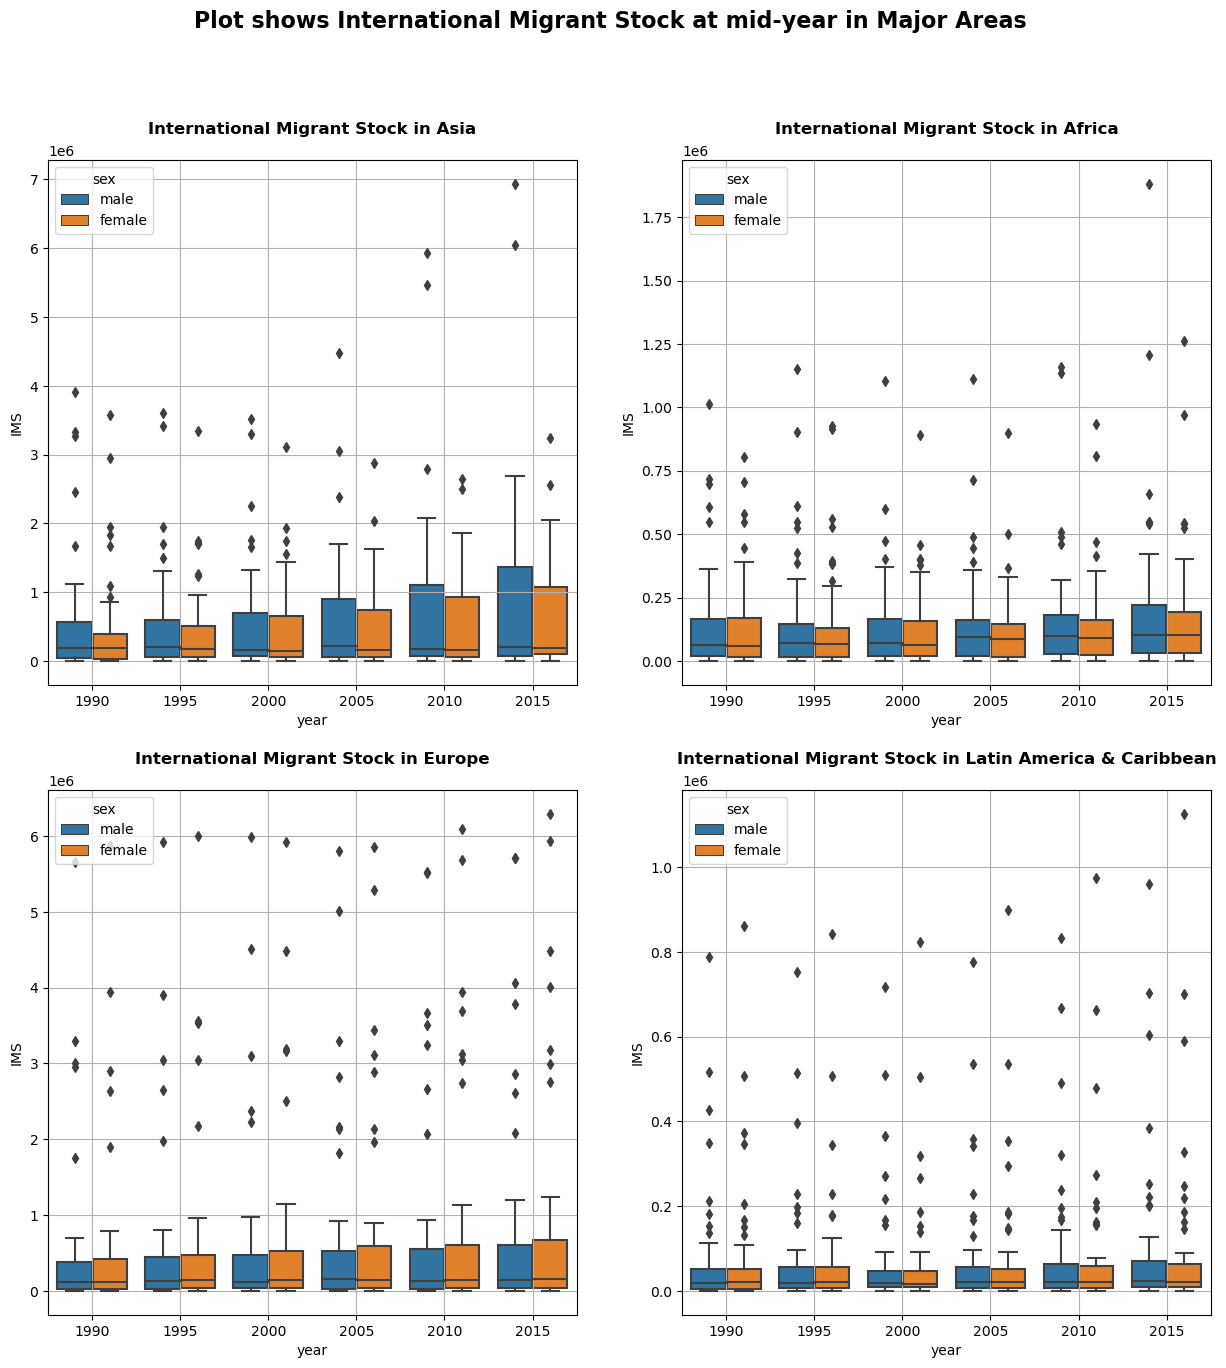

In [64]:
df1 = df[df['sex'] != 'both']

f, ax = plt.subplots(2,2, figsize=(15,15))
f.suptitle('Plot shows International Migrant Stock at mid-year in Major Areas',fontweight='bold',fontsize=16)


ax[0,0].set_title('International Migrant Stock in Asia\n',fontweight="bold")
sns.boxplot(ax = ax[0,0], data=df1[df1['major_area'] == 'Asia'], x="year", y="IMS", hue="sex")
ax[0,0].set_ylabel('IMS')
ax[0,0].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[0,0].grid()

ax[0,1].set_title('International Migrant Stock in Africa\n',fontweight="bold")
sns.boxplot(ax = ax[0,1], data=df1[df1['major_area'] == 'Africa'], x="year", y="IMS", hue="sex" )
ax[0,1].set_ylabel('IMS')
ax[0,1].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[0,1].grid()

ax[1,0].set_title('International Migrant Stock in Europe\n',fontweight="bold")
sns.boxplot(ax = ax[1,0], data=df1[df1['major_area'] == 'Europe'], x="year", y="IMS", hue="sex" )
ax[1,0].set_ylabel('IMS')
ax[1,0].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[1,0].grid()

ax[1,1].set_title('International Migrant Stock in Latin America & Caribbean\n',fontweight="bold")
sns.boxplot(ax = ax[1,1], data=df1[df1['major_area'] == 'Latin America and the Caribbean'], x="year", y="IMS", hue="sex" )
ax[1,1].set_ylabel('IMS')
ax[1,1].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[1,1].grid()

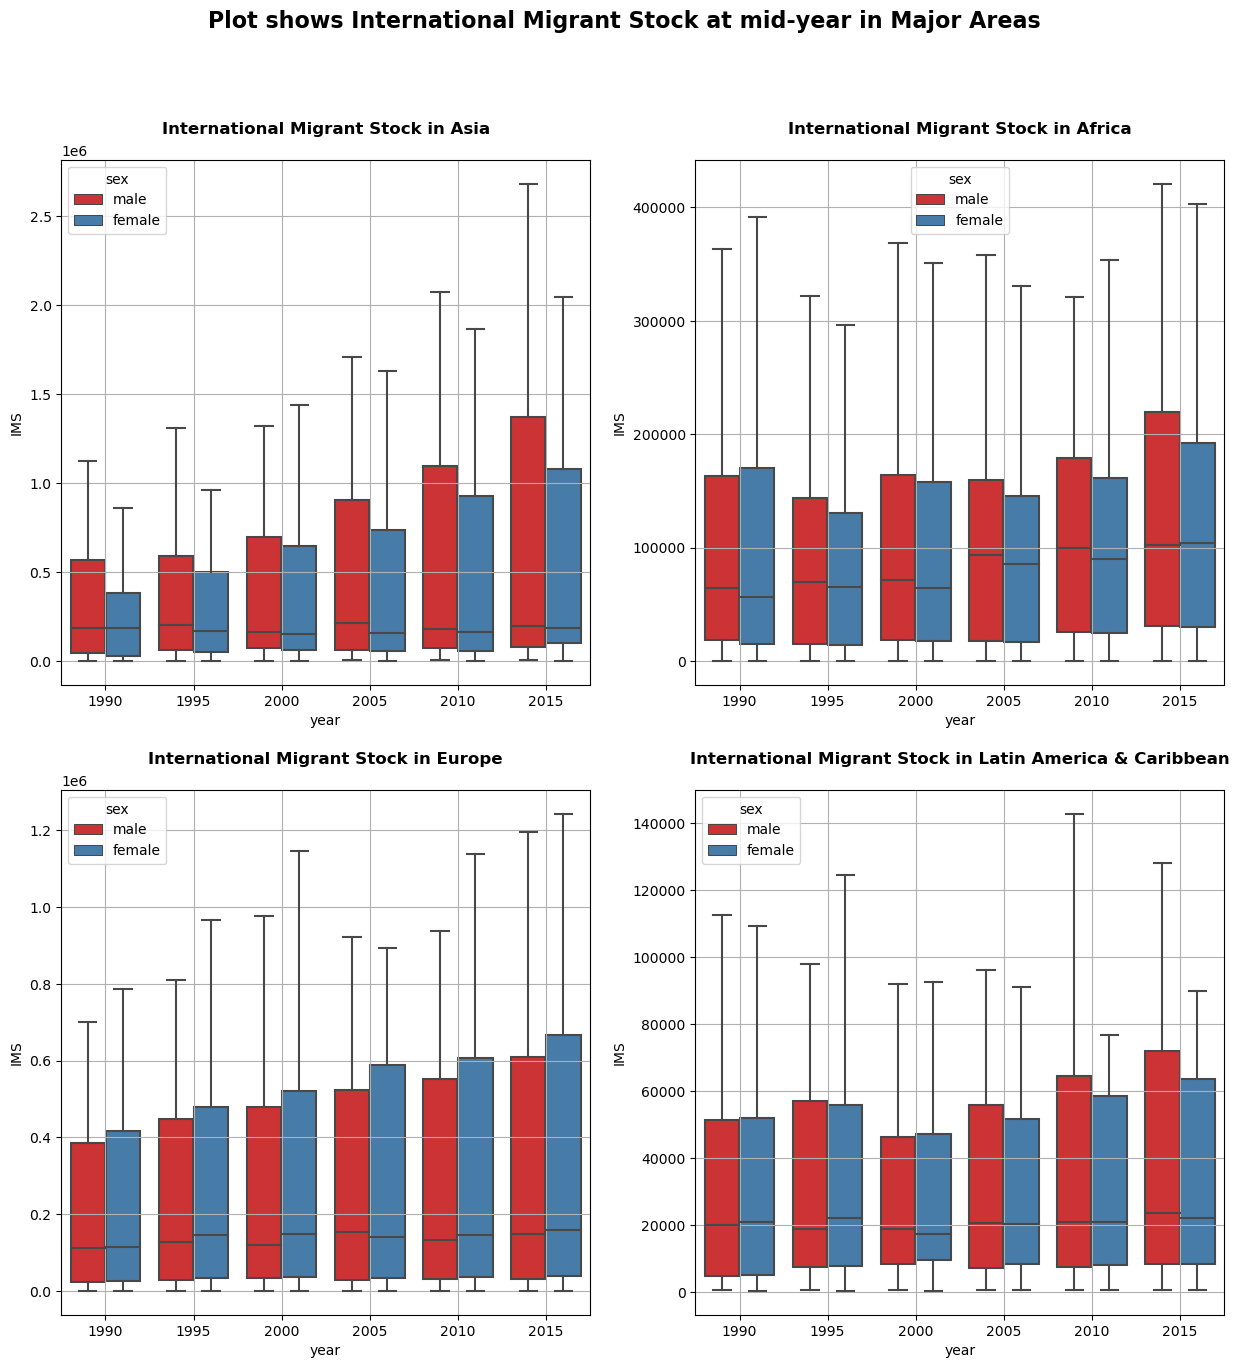

In [65]:
df1 = df[df['sex'] != 'both']

f, ax = plt.subplots(2,2, figsize=(15,15))
f.suptitle('Plot shows International Migrant Stock at mid-year in Major Areas',fontweight='bold',fontsize=16)


ax[0,0].set_title('International Migrant Stock in Asia\n',fontweight="bold")
sns.boxplot(ax = ax[0,0], data=df1[df1['major_area'] == 'Asia'], x="year", y="IMS", hue="sex" ,showfliers=False, palette= 'Set1')
ax[0,0].set_ylabel('IMS')
ax[0,0].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[0,0].grid()

ax[0,1].set_title('International Migrant Stock in Africa\n',fontweight="bold")
sns.boxplot(ax = ax[0,1], data=df1[df1['major_area'] == 'Africa'], x="year", y="IMS", hue="sex",showfliers=False, palette='Set1' )
ax[0,1].set_ylabel('IMS')
ax[0,1].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[0,1].grid()

ax[1,0].set_title('International Migrant Stock in Europe\n',fontweight="bold")
sns.boxplot(ax = ax[1,0], data=df1[df1['major_area'] == 'Europe'], x="year", y="IMS", hue="sex" ,showfliers=False, palette='Set1')
ax[1,0].set_ylabel('IMS')
ax[1,0].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[1,0].grid()

ax[1,1].set_title('International Migrant Stock in Latin America & Caribbean\n',fontweight="bold")
sns.boxplot(ax = ax[1,1], data=df1[df1['major_area'] == 'Latin America and the Caribbean'], x="year", y="IMS", hue="sex",showfliers=False, palette='Set1')
ax[1,1].set_ylabel('IMS')
ax[1,1].set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax[1,1].grid()

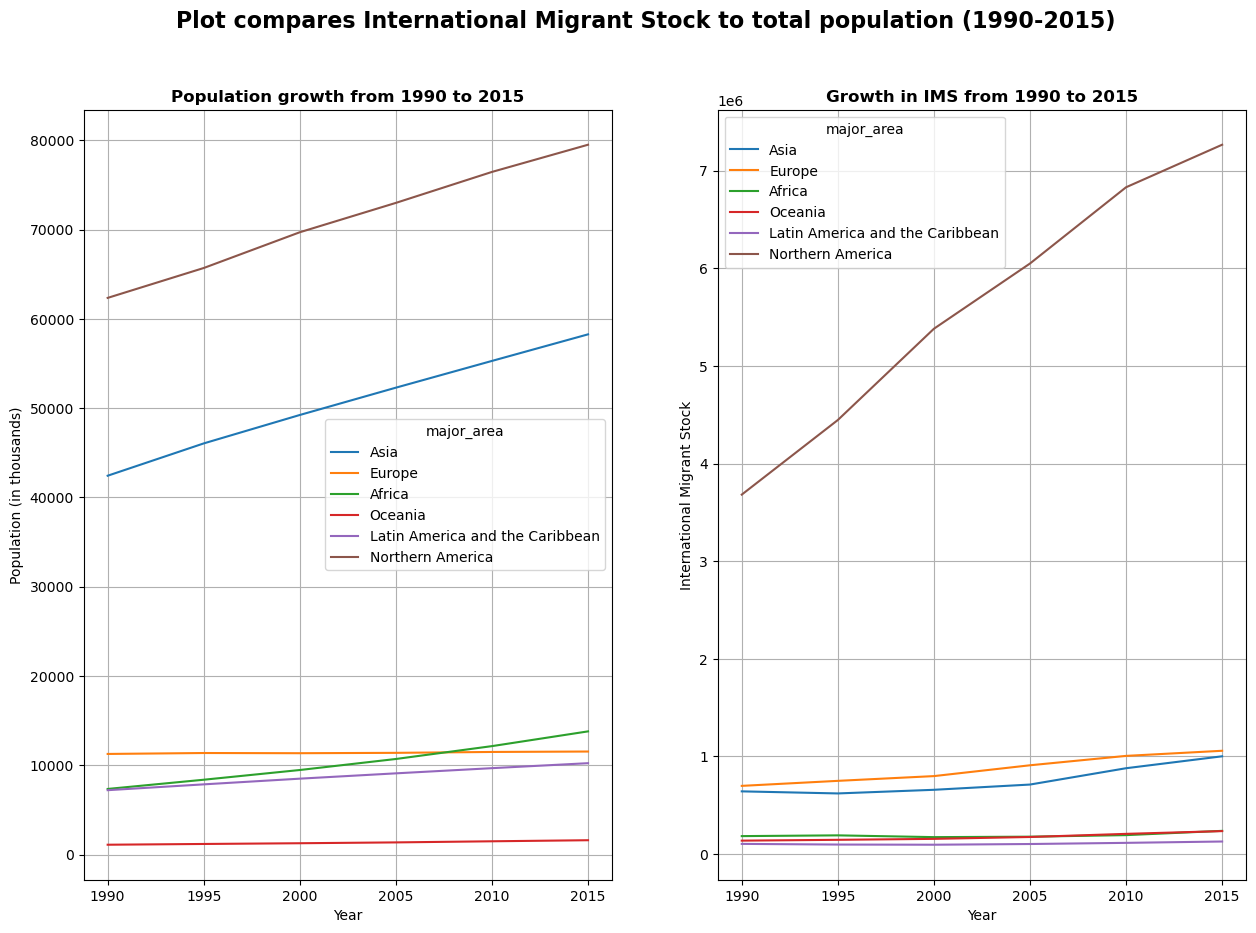

In [62]:
#df1 = df[df['major_Area']]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

f.suptitle('Plot compares International Migrant Stock to total population (1990-2015)',fontweight='bold',fontsize=16)


ax1.set_title('Population growth from 1990 to 2015',fontweight="bold")
sns.lineplot(ax = ax1, data=df, x="year", y="total_population", hue="major_area" , ci=None)
ax1.set_ylabel('Population (in thousands)')
ax1.set_xlabel('Year')
ax1.set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax1.grid()

ax2.set_title('Growth in IMS from 1990 to 2015',fontweight="bold")
sns.lineplot(ax = ax2, data=df, x="year", y="IMS" , hue = 'major_area' , ci = None)
ax2.set_xticklabels(['1990','1995','2000','2005','2010','2015'])
ax2.set_ylabel('International Migrant Stock')
ax2.set_xlabel('Year')
ax2.grid()